# Determine Forest Cover Types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Attribute Information - From Dataset Description 


Name / Data Type / Measurement / Description 

Elevation / quantitative /meters / Elevation in meters<br> 
Aspect / quantitative / azimuth / Aspect in degrees azimuth<br> 
Slope / quantitative / degrees / Slope in degrees<br> 
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features<br> 
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features<br>
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway<br> 
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice<br> 
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice<br> 
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice<br> 
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points<br> 
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation<br> 
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation<br> 
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation<br>

In [2]:
#Names taken from above
wild_area = ['Wilderness_Area_{}'.format(i) for i in range(1,5)]
soil_type = ['Soil_Type_{}'.format(i) for i in range(1,41)]

names = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points']+wild_area + soil_type +['Cover_Type']
data = pd.read_csv('covtype.data', names=names)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [3]:
data[['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points']].describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000


## Data Exploration
* Examine class distributions
* Build a baseline classifier
* Explore numerical parameters
* Explore binary parameters
* Explore relationships between numerical and binary parameters

### Class Distribution

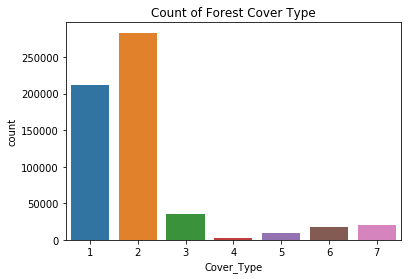

In [4]:
params = data.drop(['Cover_Type'], axis=1)
target = data['Cover_Type']

sns.countplot(data['Cover_Type']);
plt.title('Count of Forest Cover Type');

### Consequences of Above Plot
* Clearly classification accuracy will not be sufficient as the classifier could generate fairly decent results by only learning rules for classifying Forest Cover Types 1 & 2
* Will need to ensure that the testing set has enough examples of Cover Types 3-7.

### Build a Balanced Training Set
* Use `StratifiedShuffleSplit` to retrieve training and testing indices of the data while maintaining original class distributions
* Use `resample` to generate a training set from the training indices that equally represents all cover types. The `test_size` paramter in `StratifiedShuffleSplit` will therefore directly determine the number of Cover Type 4 samples in the training and testing sets.
* Put remaining indices back in test set
* Extract a cross validations set from the test set using `train_test_split`

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(params, target):
    train_index, test_index = train_index, test_index
    
#Cover Type 4 is the smallest class and therefore determines the number of samples needed from each class to generate
#a training set with balanced class distribution

n_samples = target.loc[train_index][target==4].count()
print 'Number of samples to be taken from each class:\n{}'.format(n_samples)

Number of samples to be taken from each class:
1373


In [7]:
#Create training set with balanced class distributions

train_indices = []
for i in range(1,8):
    train_indices.extend(resample(target.loc[train_index][target==i], replace=False, n_samples=n_samples, random_state=0).index)


test_add = list(set(train_index).difference(set(train_indices)))
test_index = np.append(test_index, test_add)

#Shuffle indices
np.random.shuffle(train_indices)
np.random.shuffle(test_index)

X_train, y_train = params.loc[train_indices], target.loc[train_indices]
X_test, y_test = params.loc[test_index], target.loc[test_index]

X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.9, random_state=0, stratify=y_test)

### Baseline Performance

In [8]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Accuracy: {:.4f}'.format(rfc.score(X_validation,y_validation)))
print(classification_report(y_validation, rfc.predict(X_validation)))


Accuracy: 0.6884
             precision    recall  f1-score   support

          1       0.68      0.75      0.71     21047
          2       0.83      0.60      0.70     28193
          3       0.74      0.78      0.76      3438
          4       0.32      0.96      0.48       137
          5       0.21      0.90      0.34       812
          6       0.49      0.81      0.61      1599
          7       0.53      0.94      0.67      1914

avg / total       0.74      0.69      0.70     57140



### Feature Importances
* Look at feature importances for `RandomForestClassifier` and get baseline performance using top 10 and top 20 features

In [9]:
feature_importances = pd.DataFrame(rfc.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
#Only display top 20 features
feature_importances.iloc[:20]

#pd.set_option('display.float_format', lambda x: '%.3f' % x)

,importance
Elevation,0.192978
Horizontal_Distance_To_Roadways,0.097878
Horizontal_Distance_To_Fire_Points,0.071687
Horizontal_Distance_To_Hydrology,0.063259
Wilderness_Area_4,0.058161
Hillshade_9am,0.056792
Aspect,0.052241
Vertical_Distance_To_Hydrology,0.051146
Hillshade_3pm,0.044760
Hillshade_Noon,0.043665


In [10]:
X_train_10 = X_train[np.array(feature_importances[:10].index)]
X_validation_10 = X_validation[np.array(feature_importances[:10].index)]

X_train_20 = X_train[np.array(feature_importances[:20].index)]
X_validation_20 = X_validation[np.array(feature_importances[:20].index)]

rfc.fit(X_train_10, y_train)
print('Results for top 10 features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation_10, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation_10))))

rfc.fit(X_train_20,y_train)
print('Results for top 20 features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation_20, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation_20))))


Results for top 10 features
Accuracy: 0.6497
             precision    recall  f1-score   support

          1       0.67      0.71      0.69     21047
          2       0.82      0.56      0.66     28193
          3       0.68      0.77      0.72      3438
          4       0.33      0.91      0.49       137
          5       0.17      0.91      0.29       812
          6       0.45      0.81      0.58      1599
          7       0.40      0.94      0.56      1914

avg / total       0.72      0.65      0.66     57140

Results for top 20 features
Accuracy: 0.6783
             precision    recall  f1-score   support

          1       0.67      0.74      0.70     21047
          2       0.83      0.59      0.69     28193
          3       0.73      0.77      0.75      3438
          4       0.31      0.93      0.47       137
          5       0.20      0.90      0.32       812
          6       0.48      0.81      0.61      1599
          7       0.49      0.93      0.65      1914

avg 

### Results of Baseline Classification
* Top 10 most important features - accuracy drops by 4 percentage points
* Top 20 most important features - accuracy drops by 1 percentage point
* The top 20 features plus any engineered features and the complete dataset will be compared, if excellent results are obtained with the top 20 features the top 10 plus engineered features will be used

### Explore Numerical Variables

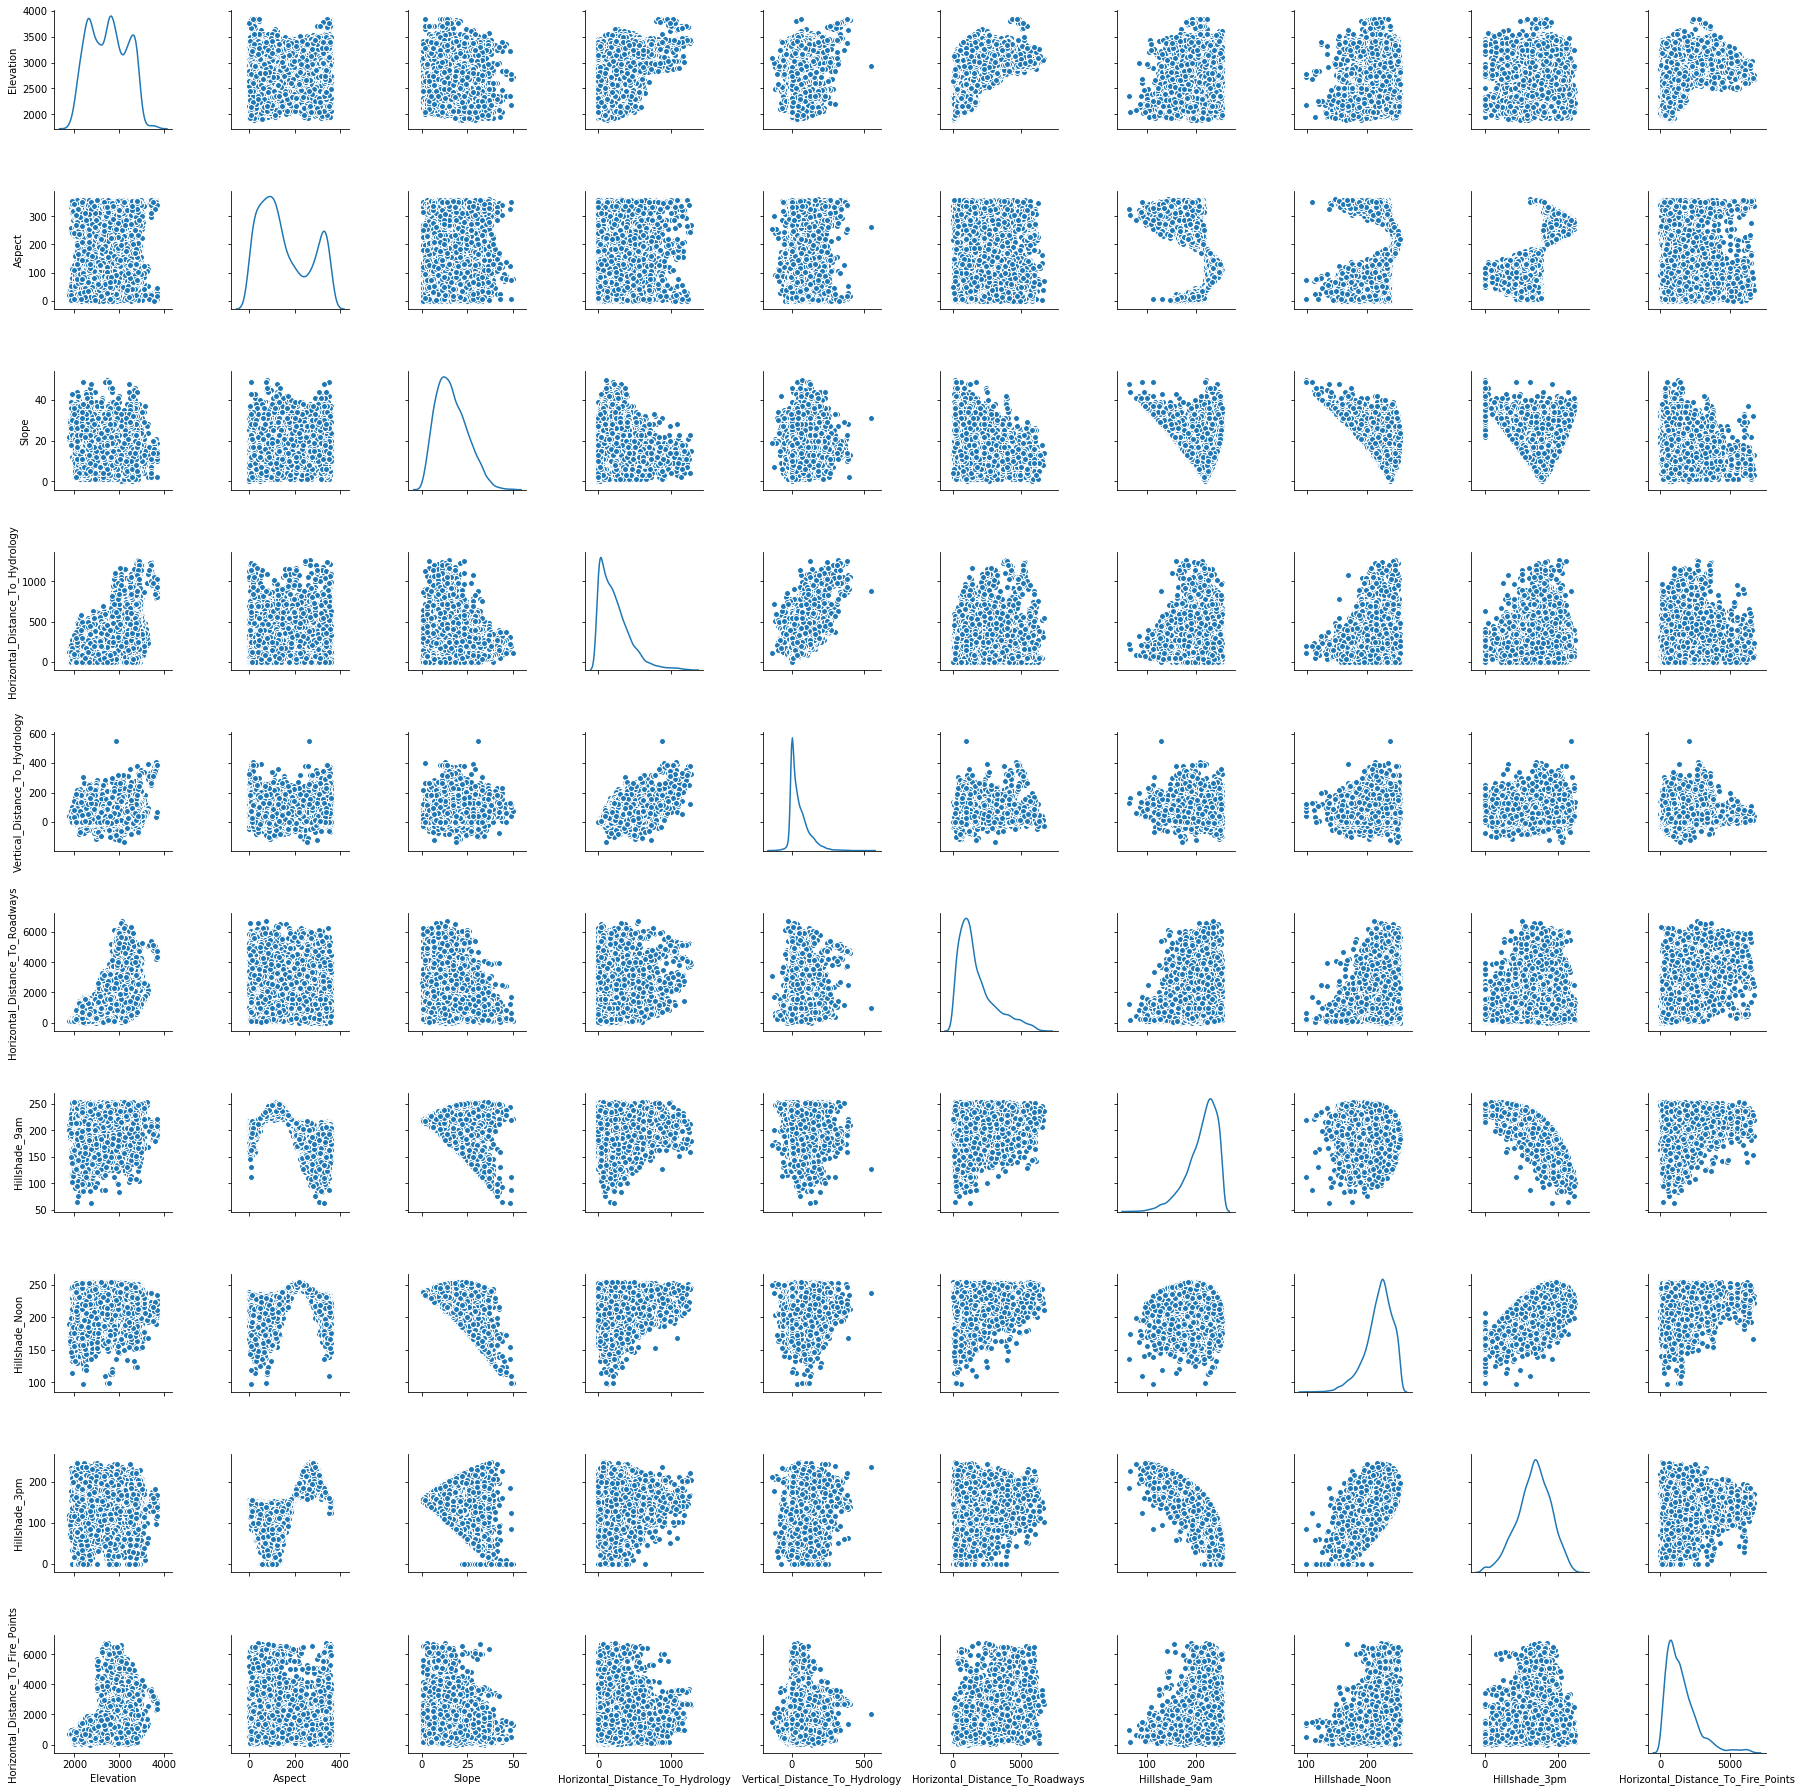

In [11]:
#Separate numerical and binary parameters so they can be examined
numerical_params = X_train.drop(soil_type+wild_area, axis=1)
binary_params = X_train[soil_type+wild_area]

sns.pairplot(numerical_params, diag_kind='kde');

### Examine Aspect, Slope, and Hillshade features in more detail

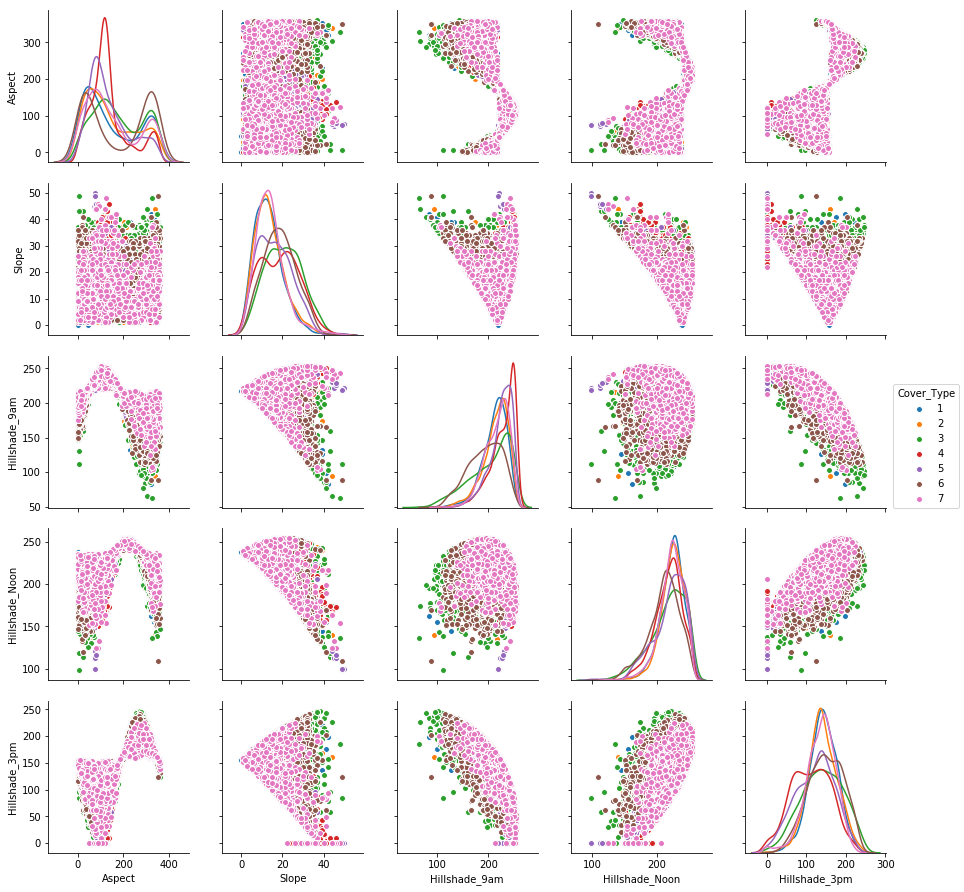

In [12]:
sns.pairplot(data[['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Cover_Type']].iloc[train_indices],
             hue='Cover_Type', diag_kind='kde', vars=['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']);

### Explore Distance Related Features in Detail

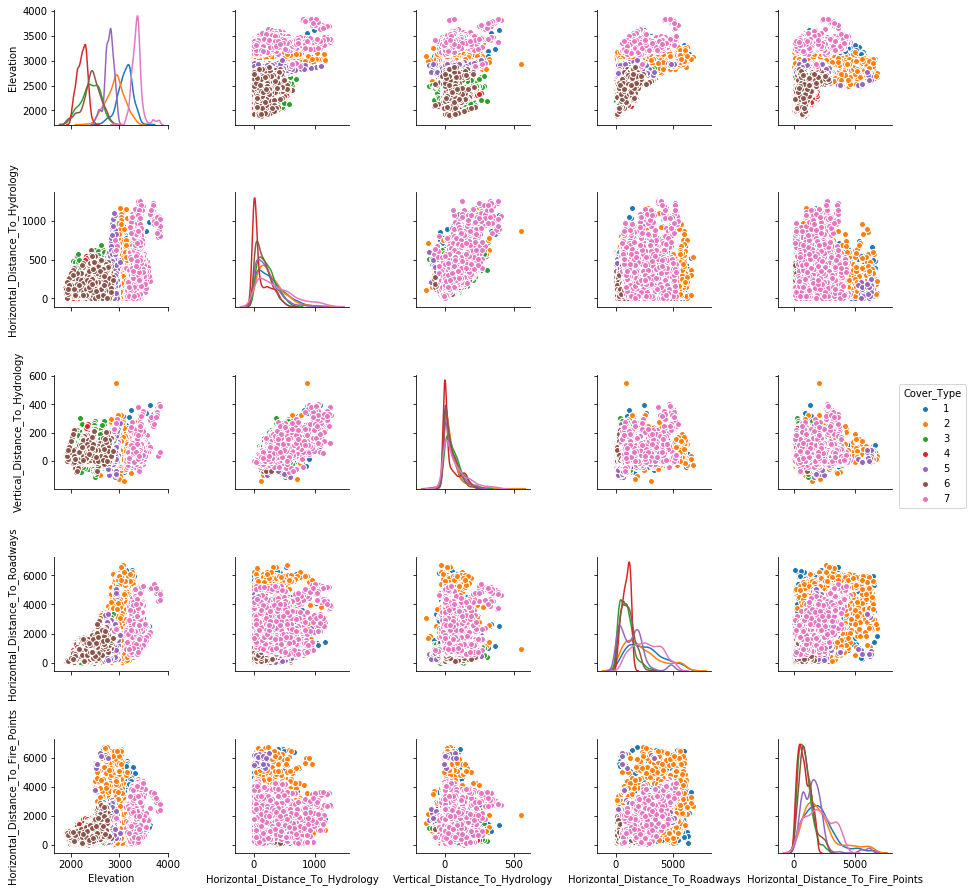

In [13]:
sns.pairplot(data[['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                   'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
                   'Cover_Type']].iloc[train_indices], hue='Cover_Type', diag_kind='kde',
            vars = ['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                   'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']);

## Feature Engineering Brainstorm

#### 1st Plot
* Something with the hillshade values, average hillshade?

#### 2nd Plot
* From this it is clear that elevation is going to be very important in helping the classifier learn to separate the various cover types
* Euclidean/shortest distance to hydrology
* Min and max distances between fire and water, fire and road, road and water; one feat could maybe be sum of fire, water, road
* Somehow make features with elevation; elevation and fire, elevation and water, vertical dist to water/elevation

In [14]:
def feature_engineering(X):
    
    #Shortest distance to water sqrt(x^2+y^2)
    X['Shortest_to_water'] = (X['Horizontal_Distance_To_Hydrology']**2+X['Vertical_Distance_To_Hydrology']**2)**0.5
    
    #Elevation minus the vertical distance to water
    X['Elev_less_vert_water'] = (X['Elevation']-X['Vertical_Distance_To_Hydrology'])
    
    #Adding the horizontal distances to fire, water, and road
    X['Sum_HDWater_Fire_Road'] = (X['Horizontal_Distance_To_Hydrology']+X['Horizontal_Distance_To_Fire_Points']+
                                  X['Horizontal_Distance_To_Roadways'])
    
    #Absolute value of the x distance to water minus the distance to fire
    X['Min_Dis_Fire_Water'] = abs(X['Horizontal_Distance_To_Hydrology']-X['Horizontal_Distance_To_Fire_Points'])
    
    #Absolute value of the distance to roads minus the distance to fire
    X['Min_Dis_Fire_Road'] = abs(X['Horizontal_Distance_To_Roadways']-X['Horizontal_Distance_To_Fire_Points'])
    
    #Absolute value of the distance to roads minus the x distance to water
    X['Min_Dis_Water_Road'] = abs(X['Horizontal_Distance_To_Roadways']-X['Horizontal_Distance_To_Hydrology'])
    
    #Experimental features and notes for possible additional features
    #X['Avg_hillshade'] = (X['Hillshade_9am']+X_train['Hillshade_Noon']+X['Hillshade_3pm'])/3
    #X['Elev_less_VHD_water'] =  (X['Elevation']-X['Vertical_Distance_To_Hydrology']-X['Horizontal_Distance_To_Hydrology'])
    
    #Something combining aspect and elevation 
    
    return X

In [15]:
X_train = feature_engineering(X_train)
X_validation = feature_engineering(X_validation)
X_test = feature_engineering(X_test)

In [16]:
rfc.fit(X_train, y_train)

feature_importances_test = pd.DataFrame(rfc.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
#Only display top 20 features
feature_importances_test.iloc[:20]


,importance
Elev_less_vert_water,0.149908
Elevation,0.145774
Sum_HDWater_Fire_Road,0.073132
Horizontal_Distance_To_Roadways,0.047309
Min_Dis_Water_Road,0.044128
Min_Dis_Fire_Water,0.040573
Min_Dis_Fire_Road,0.039278
Horizontal_Distance_To_Fire_Points,0.035701
Aspect,0.035054
Hillshade_9am,0.035051


#### All engineered features made it into the top 20

### Run classification with engineered features

In [17]:
#Build training, validation, and test sets using top 20 features
X_train_20 = X_train[np.array(feature_importances_test[:20].index)]
X_validation_20 = X_validation[np.array(feature_importances_test[:20].index)]
X_test_20 = X_test[np.array(feature_importances_test[:20].index)]

In [18]:
rfc.fit(X_train_20,y_train)
print('Results for top 20 features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation_20, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation_20))))

rfc.fit(X_train, y_train)
print('Results using all features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation))))

Results for top 20 features
Accuracy: 0.7114
             precision    recall  f1-score   support

          1       0.71      0.76      0.73     21047
          2       0.86      0.63      0.72     28193
          3       0.76      0.81      0.79      3438
          4       0.41      0.93      0.57       137
          5       0.22      0.94      0.36       812
          6       0.52      0.86      0.65      1599
          7       0.49      0.95      0.65      1914

avg / total       0.76      0.71      0.72     57140

Results using all features
Accuracy: 0.7165
             precision    recall  f1-score   support

          1       0.70      0.77      0.74     21047
          2       0.86      0.63      0.73     28193
          3       0.78      0.81      0.79      3438
          4       0.43      0.96      0.59       137
          5       0.22      0.92      0.36       812
          6       0.53      0.85      0.65      1599
          7       0.53      0.96      0.68      1914

avg /

## Classifier Optimization using [hypopt](https://pypi.org/project/hypopt/)

In [19]:
from hypopt import GridSearch

params = {'n_estimators': range(420,435,5), 'min_samples_split':range(2,11), 'min_samples_leaf':range(1,9)}

grid_obj = GridSearch(model = rfc)
grid_obj.fit(X_train_20, y_train, params, X_validation_20, y_validation)
#print('Test Score for Optimized Parameters:', grid_obj.score(X_test_20, y_test))

Comparing 216 parameter setting(s) using 8 CPU thread(s) ( 27 job(s) per thread ).


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, n_estimators=420, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [20]:
grid_obj.get_best_params()

{'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 430}

In [21]:
rfc_test = RandomForestClassifier(n_estimators=430, random_state=0)
rfc_test.fit(X_train_20, y_train)
rfc_test.score(X_test_20, y_test)

0.738166028534149